<a href="https://colab.research.google.com/github/TanviJesmi-git/Sentiment-Analysis-on-tweets/blob/main/sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp "/content/kaggle (1).json" ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d kazanova/sentiment140


Dataset URL: https://www.kaggle.com/datasets/kazanova/sentiment140
License(s): other
  0% 0.00/80.9M [00:00<?, ?B/s]
100% 80.9M/80.9M [00:00<00:00, 1.69GB/s]


In [ ]:
from zipfile import ZipFile
dataset = '/content/sentiment140.zip'
with ZipFile(dataset,'r') as zip:
  zip.extractall()
  print('done')

done


In [ ]:
import numpy
import pandas as pd
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
print(stopwords.words('english'))

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

In [ ]:
twitter_data = pd.read_csv('/content/training.1600000.processed.noemoticon.csv',encoding='latin-1')

In [ ]:
twitter_data.shape

(1599999, 6)

In [ ]:
twitter_data.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [ ]:
columnname=['target','id','date','flag','user','text']
twitter_data =pd.read_csv('/content/training.1600000.processed.noemoticon.csv',encoding='latin-1',names=columnname)

In [ ]:
twitter_data.shape

(1600000, 6)

In [ ]:
twitter_data.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
twitter_data.isna().sum()

,0
target,0
id,0
date,0
flag,0
user,0
text,0


In [ ]:
twitter_data['target'].value_counts()

,count
target,
0,800000
4,800000


In [ ]:
twitter_data.replace({'target':{4:1}},inplace=True)

In [ ]:
twitter_data['target'].value_counts()

,count
target,
0,800000
1,800000


In [ ]:
from nltk.stem.porter import PorterStemmer
import re
stemmer = PorterStemmer()

In [ ]:
def stemming(content):
  stemmed_content = re.sub(r'http[s]?://\S+|www\.\S+', '', content)   # remove URLs
  stemmed_content = re.sub(r"@\w+", "", content)                      # remove @mentions
  stemmed_content = re.sub(r"#(\w+)", r"\1", content)                 # keep hashtag text
  stemmed_content = re.sub('[^a-zA-Z]',' ',content)
  stemmed_content = stemmed_content.lower()
  stemmed_content = stemmed_content.split()
  stemmed_content = [stemmer.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
  stemmed_content = ' '.join(stemmed_content)

  return stemmed_content


In [ ]:
twitter_data['stemmed_content']=twitter_data['text'].apply(stemming)

In [ ]:
twitter_data.head()

,target,id,date,flag,user,text,stemmed_content
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",switchfoot http twitpic com zl awww bummer sho...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,upset updat facebook text might cri result sch...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,kenichan dive mani time ball manag save rest g...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,whole bodi feel itchi like fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",nationwideclass behav mad see


In [ ]:
test_text = "Check this out http://twitpic.com/2y1zl amazing!"
print(re.sub(r'http[s]?://\S+|www\.\S+', '', test_text))


Check this out  amazing!


In [ ]:
print(twitter_data[['text','stemmed_content','target']].sample(5))

                                                      text  \
697316   @TheDannyNoriega It's Pittsburgh, hun.. what's...   
179210                         Is on break...I'm so tired    
1317092  @jm_anderson Hi, you have any questions aboiut...   
951208                                    @ifonearth_open    
1059181            @petebw Take some pictures, Mr. Watson    

                                           stemmed_content  target  
697316   thedannynoriega pittsburgh hun love wish could...       0  
179210                                          break tire       0  
1317092  jm anderson hi question aboiut brownbook pleas...       1  
951208                                      ifonearth open       1  
1059181                       petebw take pictur mr watson       1  


In [ ]:
# Split
from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(twitter_data["stemmed_content"], twitter_data["target"],
                                                    test_size=0.3, random_state=42, stratify=twitter_data["target"])
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp,
                                                test_size=0.5, random_state=42, stratify=y_temp)

print("Split complete")
print("Train size:", len(X_train), "Val size:", len(X_val), "Test size:", len(X_test))

# Tokenization
max_words = 50000
max_len = 50
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_pad = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_len, padding="post")
X_val_pad = pad_sequences(tokenizer.texts_to_sequences(X_val), maxlen=max_len, padding="post")
X_test_pad = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_len, padding="post")

print("Tokenization complete")
print("Effective vocab size (used):", tokenizer.num_words)
print("Full vocab size (all unique words):", len(tokenizer.word_index))
print("Example padded sequence:", X_train_pad[0][:20])


Split complete
Train size: 1120000 Val size: 240000 Test size: 240000
Tokenization complete
Effective vocab size (used): 50000
Full vocab size (all unique words): 422721
Example padded sequence: [   1  104  177 1901  587 2611  283  150  341  178    0    0    0    0
    0    0    0    0    0    0]


In [ ]:
from keras.regularizers import l2
model = Sequential([
    Embedding(max_words, 128),
    SpatialDropout1D(0.3),
    Bidirectional(LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)),
    Bidirectional(LSTM(64, dropout=0.3, recurrent_dropout=0.3)),
    Dense(32, activation="relu", kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.0005), metrics=["accuracy"])
model.build(input_shape=(None, max_len))
print(model.summary())




Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 50, 128)        │     6,400,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 50, 128)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 50, 256)        │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,831,681 (26.06 MB)

 Trainable params: 6,831,681 (26.06 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
callbacks = [
    EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=2, verbose=1)
]

history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=12,
    batch_size=512,
    callbacks=callbacks,
    verbose=1
)

print("Training complete")


Epoch 1/12
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 1328s 600ms/step - accuracy: 0.7295 - loss: 0.5457 - val_accuracy: 0.7813 - val_loss: 0.4612 - learning_rate: 5.0000e-04
Epoch 2/12
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 1313s 600ms/step - accuracy: 0.7883 - loss: 0.4568 - val_accuracy: 0.7841 - val_loss: 0.4554 - learning_rate: 5.0000e-04
Epoch 3/12
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 1303s 596ms/step - accuracy: 0.7968 - loss: 0.4419 - val_accuracy: 0.7849 - val_loss: 0.4538 - learning_rate: 5.0000e-04
Epoch 4/12
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 1296s 592ms/step - accuracy: 0.8023 - loss: 0.4306 - val_accuracy: 0.7860 - val_loss: 0.4555 - learning_rate: 5.0000e-04
Epoch 5/12
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 0s 566ms/step - accuracy: 0.8089 - loss: 0.4192
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 1285s 587ms/step - accuracy: 0.8089 - loss: 0.4192 - val_accuracy: 0.7864 - val_loss: 0.4581 - learning_rate: 5.0000e-04
Epoch 6/12
2188/2188 ━━━━━━━━

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

7500/7500 ━━━━━━━━━━━━━━━━━━━━ 738s 98ms/step
✅ Evaluation
Accuracy: 0.7839333333333334

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.80      0.79    120000
           1       0.79      0.77      0.78    120000

    accuracy                           0.78    240000
   macro avg       0.78      0.78      0.78    240000
weighted avg       0.78      0.78      0.78    240000



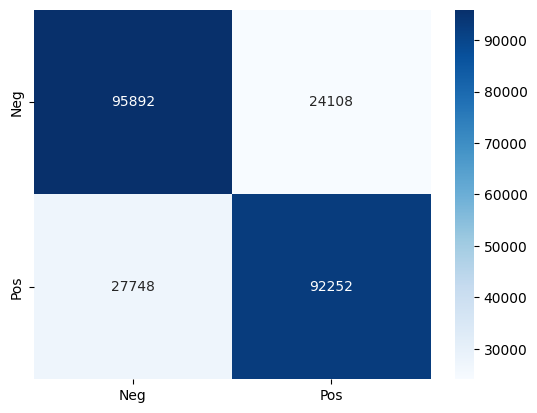

In [ ]:
y_pred_proba = model.predict(X_test_pad)
y_pred = (y_pred_proba > 0.5).astype(int)

print("✅ Evaluation")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Neg","Pos"], yticklabels=["Neg","Pos"])
plt.show()


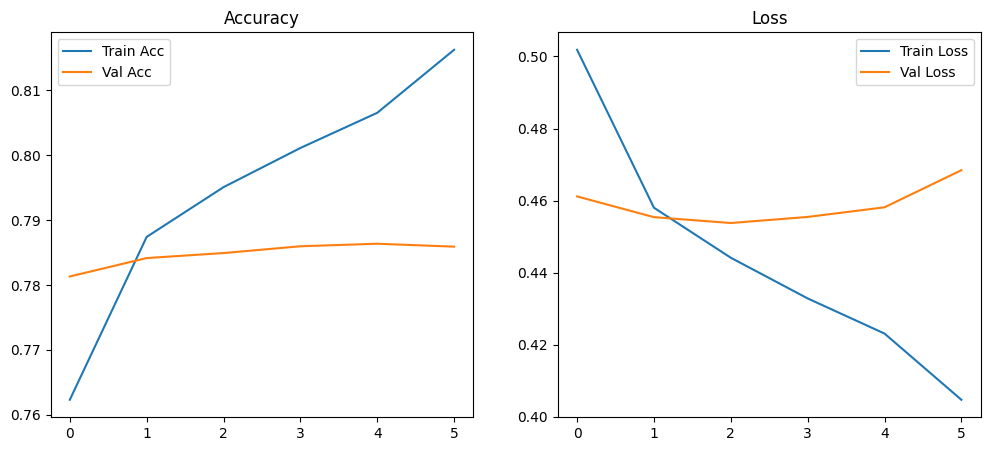

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.legend(); plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend(); plt.title("Loss")
plt.show()


In [ ]:
def predict_sentiment(texts):
    seq = pad_sequences(tokenizer.texts_to_sequences(texts), maxlen=max_len, padding="post")
    probs = model.predict(seq)
    for i, t in enumerate(texts):
        label = "Positive 😀" if probs[i] > 0.5 else "Negative 😡"
        print(f"Tweet: {t}\n → {label} (Confidence: {probs[i][0]:.3f})\n")

test_tweets = [
    "I absolutely love this new phone!",
    "This is the worst movie ever.",
    "Traffic is terrible today",
    "Feeling so happy and blessed"
]
predict_sentiment(test_tweets)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Tweet: I absolutely love this new phone!
 → Positive 😀 (Confidence: 0.855)

Tweet: This is the worst movie ever.
 → Negative 😡 (Confidence: 0.133)

Tweet: Traffic is terrible today
 → Negative 😡 (Confidence: 0.106)

Tweet: Feeling so happy and blessed
 → Positive 😀 (Confidence: 0.704)

